In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout




In [2]:

# importar datos xls de generacion de energia PPC

df = pd.read_excel('gen_2022.xlsx', sheet_name='Datos_Potencia_2022')
# join Date and Time into one column and convert to datetime using strptime
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))
# drop Date and Time columns
df.drop(['Date', 'Time'], axis=1, inplace=True)
# set Date column as index
df.set_index('DateTime', inplace=True)
# calcular energia en Kw/h
df['Energia Kwh'] = df['Valle - PPC - TOTAL AC ACTIVE POWER (kW)'] / 60
# agrupar ene rgia cada 5 minutos
df = df.resample('5T').sum()
# dividir la columna de Valle - PPC - ACTIVE POWER SETPOINT (kW) entre 5
df["Valle - PPC - ACTIVE POWER SETPOINT (kW)"] = df["Valle - PPC - ACTIVE POWER SETPOINT (kW)"] / 5
# Eliminar columna Valle - PPC - TOTAL AC ACTIVE POWER (kW)	
df.drop(['Valle - PPC - TOTAL AC ACTIVE POWER (kW)'], axis=1, inplace=True)

# importar datos xls de radiacion solar
df2 = pd.read_excel('gen_2022.xlsx', sheet_name='Datos_Recurso_Solar_2022')
# join Date and Time into one column and convert to datetime using strptime
df2['DateTime'] = pd.to_datetime(df2['Date'].astype(str) + ' ' + df2['Time'].astype(str))
# drop Date and Time columns
df2.drop(['Date', 'Time'], axis=1, inplace=True)
# set Date column as index
df2.set_index('DateTime', inplace=True)

# importar datos xls de temperatura
df3 = pd.read_excel('gen_2022.xlsx', sheet_name='temperatura')
# join Date and Time into one column and convert to datetime using strptime
df3['DateTime'] = pd.to_datetime(df3['Date'].astype(str) + ' ' + df3['Time'].astype(str))
# drop Date and Time columns
df3.drop(['Date', 'Time'], axis=1, inplace=True)
# set Date column as index
df3.set_index('DateTime', inplace=True)

# agregar columan de Irradiancia media (W/m2) de df2 a df
df['Irradiancia media (W/m2)'] = df2['Irradiancia media (W/m2)']
# agregar columan de Temperatura media (°C) de df3 a df
df['Temperatura media (°C)'] = df3['Temperatura panel promedio - (ºC)']


In [3]:
# create from datetime index a column of hours,monts,day
df['Hour'] = df.index.hour
df['Month'] = df.index.month
df['Day'] = df.index.day
df.head()


,Valle - PPC - ACTIVE POWER SETPOINT (kW),Energia Kwh,Irradiancia media (W/m2),Temperatura media (°C),Hour,Month,Day
DateTime,,,,,,,
2022-01-01 00:00:00,50000.0,-10.544850,NaN,NaN,0,1,1
2022-01-01 00:05:00,50000.0,-10.526300,-3.127231,19.325083,0,1,1
2022-01-01 00:10:00,50000.0,-10.530717,-3.089154,19.282083,0,1,1
2022-01-01 00:15:00,50000.0,-10.671283,-2.865615,19.229000,0,1,1
2022-01-01 00:20:00,50000.0,-10.486217,-2.904385,19.199667,0,1,1


In [4]:
# Funciones
# Funcion de imputacion de datos faltantes
def imputacion_lineal(df):
    df = df.interpolate(method='linear', limit_direction='forward', axis=0)
    df.fillna(0, inplace=True)
    return df

# Funcion para reemplazar valores NaN por 0
def reemplazar_nan(df):
    df.fillna(0, inplace=True)
    return df

In [8]:
# Imputacion de NaNs usando interpolacion lineal
df = imputacion_lineal(df)
# replace nan values with 0
df.fillna(0, inplace=True)
# count number of NaN values in dataframe
print(df.isnull().sum())

# Copiar datos de generacion de energia
df_gen = df.copy()
# Eliminar registros donde Valle - PPC - ACTIVE POWER SETPOINT (kW) < 50000
df_gen = df_gen[df_gen['Valle - PPC - ACTIVE POWER SETPOINT (kW)'] >= 50000]
# Eliminar registros donde Energia Kwh <= 0
df_gen = df_gen[df_gen['Energia Kwh'] > 0]
# Eliminar registros donde Energia Kwh > 4000
df_gen = df_gen[df_gen['Energia Kwh'] <= 4150]
# Eliminar registros donde Irradiancia media (W/m2) <= 20
df_gen = df_gen[df_gen['Irradiancia media (W/m2)'] > 20]
df_gen.head()

Valle - PPC - ACTIVE POWER SETPOINT (kW)    0
Energia Kwh                                 0
Irradiancia media (W/m2)                    0
Temperatura media (°C)                      0
Hour                                        0
Month                                       0
Day                                         0
dtype: int64


,Valle - PPC - ACTIVE POWER SETPOINT (kW),Energia Kwh,Irradiancia media (W/m2),Temperatura media (°C),Hour,Month,Day
DateTime,,,,,,,
2022-01-01 06:30:00,50000.0,90.330383,33.933769,16.942273,6,1,1
2022-01-01 06:35:00,50000.0,152.545200,57.114308,16.980250,6,1,1
2022-01-01 06:40:00,50000.0,218.782100,81.989923,17.259667,6,1,1
2022-01-01 06:45:00,50000.0,296.787717,109.117077,17.669417,6,1,1
2022-01-01 06:50:00,50000.0,416.128133,132.461231,18.132000,6,1,1


In [9]:
# Function to split data into train, test and validation sets
def train_test_val_split(df):
    # split data into train and test sets
    train, test = train_test_split(df, test_size=0.2, random_state=42)
    # split train data into train and validation sets
    train, val = train_test_split(train, test_size=0.2, random_state=42)
    return train, test, val

# split data into train, test and validation sets
train, test, val = train_test_val_split(df_gen)

# split data into X and y , x is Irradiancia media (W/m2)	and Temperatura media (°C)	, y is Energia Kwh
X_train = train[['Irradiancia media (W/m2)', 'Temperatura media (°C)', 'Month', 'Day', 'Hour']]
y_train = train['Energia Kwh']
X_test = test[['Irradiancia media (W/m2)', 'Temperatura media (°C)', 'Month', 'Day', 'Hour']]
y_test = test['Energia Kwh']
X_val = val[['Irradiancia media (W/m2)', 'Temperatura media (°C)', 'Month', 'Day', 'Hour']]
y_val = val['Energia Kwh']

# normalizar datos usando StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)



In [88]:
# Crear un modelo de deep learning más profundo
neurons = 64
model_nn = keras.Sequential([
    layers.Dense(neurons, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(neurons, activation='relu'),
    layers.Dense(neurons, activation='relu'),
    layers.Dense(neurons, activation='relu'),
    layers.Dense(neurons, activation='relu'),
    layers.Dense(neurons, activation='relu'),
    layers.Dense(1)
])

# compile model
model_nn.compile(
    optimizer='adam',
    loss='mae',
    metrics=['mae'])

# early stopping
early_stopping = keras.callbacks.EarlyStopping(
    patience=50,
    min_delta=0.001,
    restore_best_weights=True)

# train model
history = model_nn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=100,
    verbose=1)

# print rsme and r2
y_pred = model_nn.predict(X_test)
y_pred = y_pred.reshape(y_pred.shape[0],)
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2 score:', r2_score(y_test, y_pred))

Epoch 1/100
333/333 [==============================] - 1s 1ms/step - loss: 650.4269 - mae: 650.4269 - val_loss: 183.1315 - val_mae: 183.1315
Epoch 2/100
333/333 [==============================] - 0s 1ms/step - loss: 154.2558 - mae: 154.2558 - val_loss: 140.0919 - val_mae: 140.0919
Epoch 3/100
333/333 [==============================] - 1s 2ms/step - loss: 135.0119 - mae: 135.0119 - val_loss: 132.2567 - val_mae: 132.2567
Epoch 4/100
333/333 [==============================] - 0s 1ms/step - loss: 131.5095 - mae: 131.5095 - val_loss: 128.8524 - val_mae: 128.8524
Epoch 5/100
333/333 [==============================] - 0s 1ms/step - loss: 128.6380 - mae: 128.6380 - val_loss: 139.4494 - val_mae: 139.4494
Epoch 6/100
333/333 [==============================] - 0s 990us/step - loss: 128.1213 - mae: 128.1213 - val_loss: 126.7750 - val_mae: 126.7750
Epoch 7/100
333/333 [==============================] - 1s 2ms/step - loss: 127.4545 - mae: 127.4545 - val_loss: 123.9262 - val_mae: 123.9262
Epoch 8/100

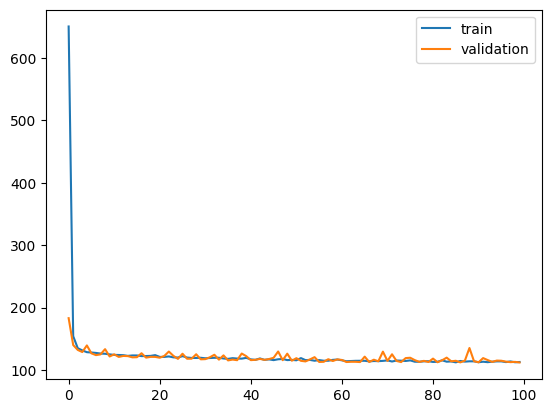

In [89]:
# plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [79]:
# save model
model_nn.save('model_nn.h5')


/home/cardenas/anaconda3/envs/gpu/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


  1/208 [..............................] - ETA: 1s

208/208 [==============================] - 0s 416us/step


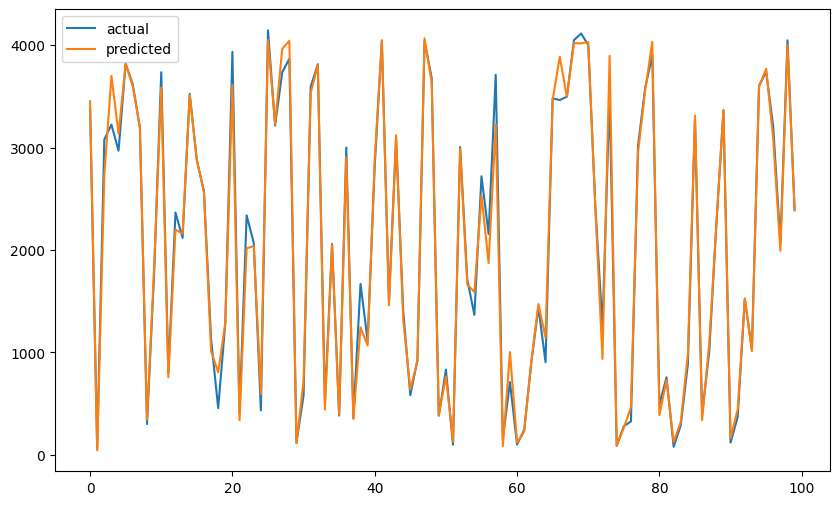

In [90]:
# plot actual and predicted values for test data
y_pred_nn = model_nn.predict(X_test)
a = 0
b = 100 + a
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[a:b], label='actual')
plt.plot(y_pred_nn[a:b], label='predicted')
plt.legend()
plt.show()


In [91]:
#  agregar columna de generacion de energia predicha a df
# agregar columna de generacion de energia predicha a df
df_final = df.copy()
df_final['Energia Kwh predicha (nn)'] = model_nn.predict(scaler.transform(df[['Irradiancia media (W/m2)', 'Temperatura media (°C)', 'Month', 'Day', 'Hour']]))
df_final.head()

   1/3285 [..............................] - ETA: 28s

3285/3285 [==============================] - 2s 465us/step


,Valle - PPC - ACTIVE POWER SETPOINT (kW),Energia Kwh,Irradiancia media (W/m2),Temperatura media (°C),Hour,Month,Day,Energia Kwh predicha (nn)
DateTime,,,,,,,,
2022-01-01 00:00:00,50000.0,-10.544850,0.000000,0.000000,0,1,1,57.053604
2022-01-01 00:05:00,50000.0,-10.526300,-3.127231,19.325083,0,1,1,60.002754
2022-01-01 00:10:00,50000.0,-10.530717,-3.089154,19.282083,0,1,1,60.011566
2022-01-01 00:15:00,50000.0,-10.671283,-2.865615,19.229000,0,1,1,60.069817
2022-01-01 00:20:00,50000.0,-10.486217,-2.904385,19.199667,0,1,1,60.058434


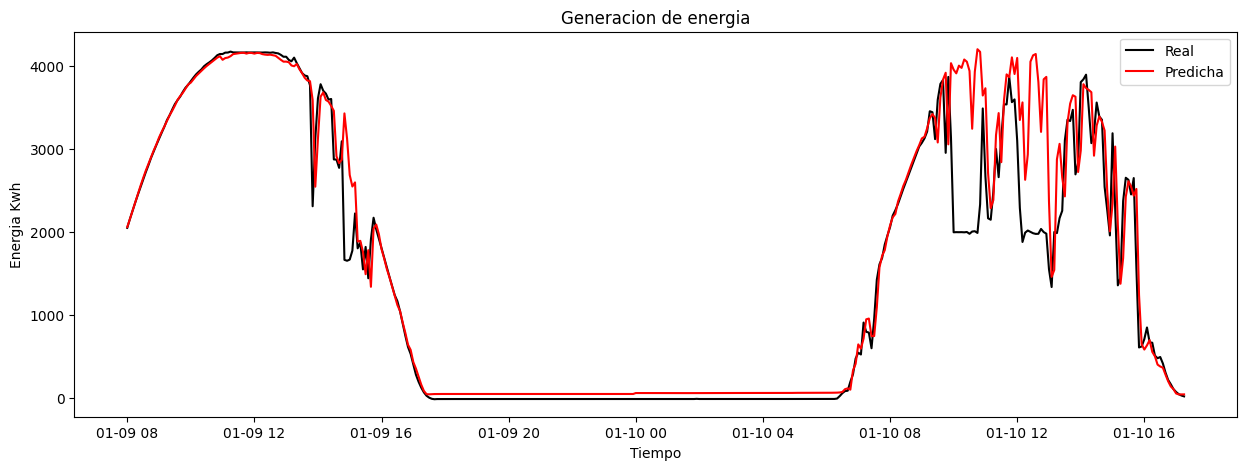

In [102]:
# plot Energia Kwh vs Energia Kwh Pred
plt.figure(figsize=(15,5))
a = 2400
b = a+400
# graficar primeros 100 registros con index
plt.plot(df_final.index[a:b], df_final['Energia Kwh'][a:b], color='black', label='Real')
plt.plot(df_final.index[a:b], df_final['Energia Kwh predicha (nn)'][a:b], color='red', label='Predicha')
plt.title('Generacion de energia')
plt.xlabel('Tiempo')
plt.ylabel('Energia Kwh')
plt.legend()
plt.show()

In [110]:
# columna de energia perdida con las siguientes condiciones 
# si Valle - PPC - ACTIVE POWER SETPOINT (kW) >= 50000 , Energia perdida = 0
# si Valle - PPC - ACTIVE POWER SETPOINT (kW) < 50000 y energía predicha > Energia Kwh , Energia perdida = (Energia predicha - Energia Kwh)
df_final['Energia perdida'] = np.where((df_final['Valle - PPC - ACTIVE POWER SETPOINT (kW)'] < 50000) & (df_final['Energia Kwh predicha (nn)'] > df_final['Energia Kwh']), df_final['Energia Kwh predicha (nn)'] - df_final['Energia Kwh'], 0)
# si Energia Kwh <0 y Valle - PPC - ACTIVE POWER SETPOINT (kW) < 50000 , Energia perdida = 0
df_final['Energia perdida'] = np.where((df_final['Energia Kwh'] < 0) & (df_final['Valle - PPC - ACTIVE POWER SETPOINT (kW)'] < 50000), 0, df_final['Energia perdida'])
df_final.head(100)



,Valle - PPC - ACTIVE POWER SETPOINT (kW),Energia Kwh,Irradiancia media (W/m2),Temperatura media (°C),Hour,Month,Day,Energia Kwh predicha (nn),Energia perdida
DateTime,,,,,,,,,
2022-01-01 00:00:00,50000.0,-10.544850,0.000000,0.000000,0,1,1,57.053604,0.0
2022-01-01 00:05:00,50000.0,-10.526300,-3.127231,19.325083,0,1,1,60.002754,0.0
2022-01-01 00:10:00,50000.0,-10.530717,-3.089154,19.282083,0,1,1,60.011566,0.0
2022-01-01 00:15:00,50000.0,-10.671283,-2.865615,19.229000,0,1,1,60.069817,0.0
2022-01-01 00:20:00,50000.0,-10.486217,-2.904385,19.199667,0,1,1,60.058434,0.0
...,...,...,...,...,...,...,...,...,...
2022-01-01 07:55:00,50000.0,1371.942800,290.474615,29.505917,7,1,1,1386.848511,0.0
2022-01-01 08:00:00,50000.0,1949.658400,344.506154,29.652167,8,1,1,1668.952759,0.0
2022-01-01 08:05:00,50000.0,2336.487583,449.102615,30.454000,8,1,1,2140.954834,0.0


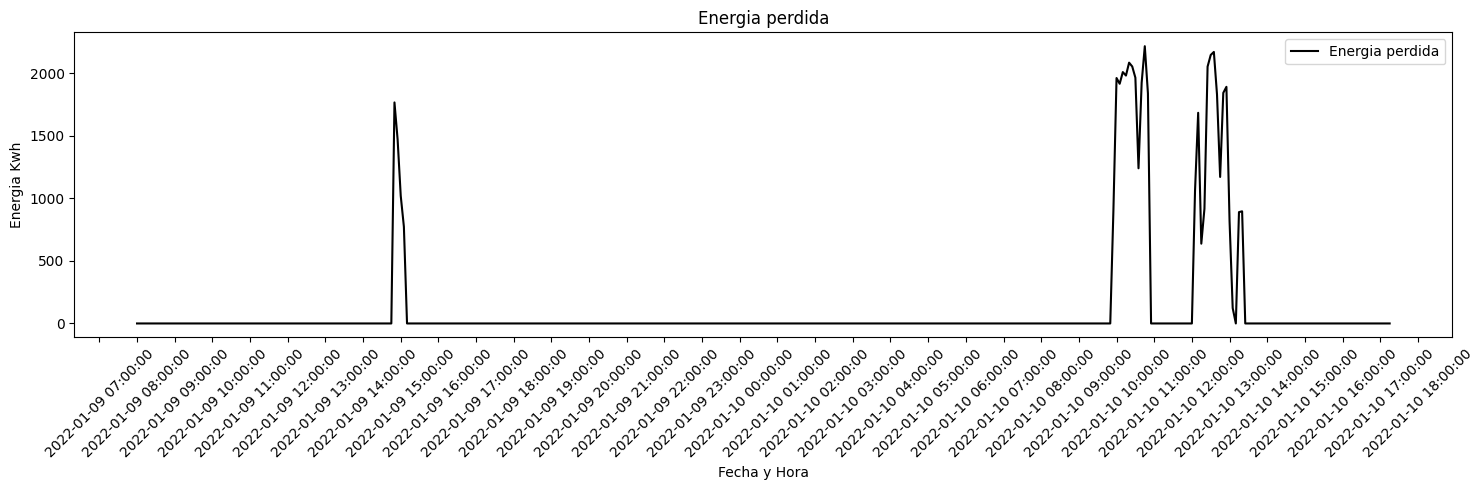

In [111]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  # Importa el módulo de fechas

# Supongamos que tienes una serie de fechas en formato datetime
# Asegúrate de que tus fechas estén en un formato adecuado, si no, puedes usar pd.to_datetime
# df_final['Fecha y Hora'] = pd.to_datetime(df_final['Fecha y Hora'])

plt.figure(figsize=(15, 5))

a = 2400
b = a + 400

# Grafica primeros 100 registros con index
plt.plot(df_final.index[a:b], df_final['Energia perdida'][a:b], color='black', label='Energia perdida')
plt.title('Energia perdida')
plt.xlabel('Fecha y Hora')
plt.ylabel('Energia Kwh')

# Formatea las fechas en el eje x para mostrar una fecha cada hora
ax = plt.gca()  # Obtiene el objeto de ejes actual
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Una fecha cada hora
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))  # Formato de fecha y hora

plt.xticks(rotation=45)  # Rota las etiquetas para una mejor legibilidad
plt.legend()
plt.tight_layout()
plt.show()


In [112]:
# save df_final to excel
df_final.to_excel('df_final.xlsx')


In [113]:
#suma de energia perdida total
df_final['Energia perdida'].sum()


19767537.560694613